In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt 
from IPython.core.debugger import set_trace #this is used for debugging
np.random.seed(1234) 

### Implementation of the Gradient
We implement the gradient function in the code below. We want the entire gradient, in the form of a matrix, the same shape as $W$. Note that although gradient is generally in the form of a vector, here, for convenience we are keeping its shape the same as the weight matrix, rather than converting it to a vector. The mathematical expression for the gradient, when using the design matrix $X$, and the one-hot coding of labels $y$ is:

$$
 g = \frac{1}{N} X^\top (\mathcal{S}(X w) - y) 
$$

In [2]:
def softmax(z):
    ''' 
    calculate the softmax function along the last dimension
    '''
    z0 = np.max(z,-1, keepdims=True) 
    z_exp = np.exp(z - z0) #to prevent underflow/overflow
    p = z_exp / np.sum(z_exp, -1, keepdims=True)
    return p

def cost(
    x, # N x D 
    yhot, # N x C: one hot coding of the labels
    w # D x C
        ):
    N, D = x.shape                    
    p = np.softmax(x @ w)
    ce_loss = -np.mean(np.sum(yhot * np.log(p), -1)) # the cost function L discussed above
    return ce_loss

def gradient(
    x, # NxD
    yhot, # NxC
    w # DxC
        ):
    
    N, D = x.shape
    grad = (1/N) * x.transpose() @ (softmax(x @ w) - yhot)
    
    return grad  # D x C matrix: the same shape as the weight matrix w


## Image Classification using Softmax Regression
We want to implement softmax regression, including the stochastic gradient descent using momentum to fit the training data. Our training data is in the form of $8x8$ image of digits 0,1,2,...,9. Therefore each input $x$ has 64 features corresponding to pixel values. The input to our classifier is therefore a vector of length 64, and the output is class probabilities. Let's load this dataset and split the data into train and test.

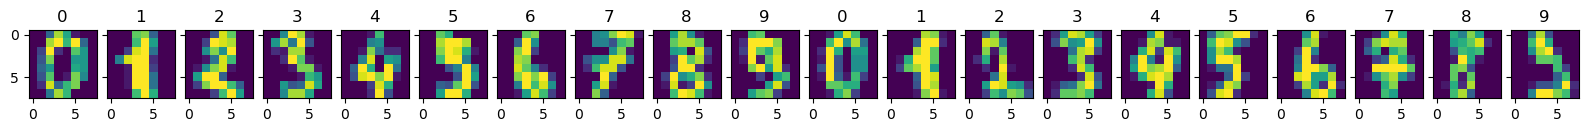

In [3]:
from sklearn.datasets import load_digits
from mpl_toolkits.axes_grid1 import ImageGrid                         #To plot the images in grid 

x, y = load_digits(return_X_y=True)
split = (80,20) # percentage for train, and test split
n = x.shape[0]
n_tr, n_ts = n*split[0]//100, n*split[1]//100
x_tr, x_ts = x[:n_tr], x[n_tr:n_tr+n_ts] 
y_tr, y_ts = y[:n_tr], y[n_tr:n_tr+n_ts] 

def plot_digits(x,y):
    num_plots = x.shape[0]
    fig = plt.figure(figsize=(num_plots, 10.*num_plots))
    grid = ImageGrid(fig, 111, nrows_ncols=(1, num_plots), axes_pad=0.1)
    for i in range(num_plots):
        grid[i].imshow(x[i].reshape((8,8)))
        grid[i].set_title(str(y[i]))
    plt.show()
plot_digits(x[:20], y[:20])  #plot 20 first instances in the dataset 

### Gradient Descent with Momentum
Below we complete the implementation of the gradient descent using momentum. We have a class that records hyper-parameters of the optimization including learning rate and momentum parameter, as well as the gradient function `grad_fn`. Each call to the step function should update the input weight `w` by calculating the gradient and using the exponential running average of the past gradients that is stored in `m`. The updated weight `wp` is returned by the `step` method.

In [4]:
class MomentumOpt:
    '''
    Implements the method of momentum for linear regression and classification.
    Each step takes the gradient function and its arguments, including w_{t} as input, 
    updates the exponential running average of gradients and returns w_{t+1}.
    '''
    def __init__(self, grad_fn, learning_rate=.001, beta = .95):
        self.grad_fn = grad_fn # the gradient function: grad_fn(x,y, w)
        self.learning_rate = learning_rate
        self.beta = beta
        self.m = None #the exponential running average of gradients
            
    def step(
        self, 
        x, # N x D 
        yhot, # N x C
        w # D+1 is the w at current time step. The first element w_0 is the bias and the rest are the weights 
        ):
        
        if type(self.m)==type(None):
            self.m = (1-self.beta)*self.grad_fn(x, yhot, w)
        else:
            self.m = self.beta*self.m + (1-self.beta)*self.grad_fn(x, yhot, w)
                 
        wp = w-self.learning_rate*self.m
        
        return wp

### Training Using Mini-Batch of Data
Now, we are ready to implement the `SoftmaxRegression` class. We have two methods, `fit`, which fits the training data by finding the model parameter `w` that minimizes the empirical risk, and the `predict` method which produces class probabilities for a given input.

Here, for the training we want to use mini-batch of size `minibatch`. Each gradient step that is performed using the optimizer `step` function that we previously implemented, should therefore use a minibatch rather than the entire trainin data for its calculations. When training using mini-batch we use the term `epoch` rather than *iteration* to refer to several iterations using mini-batch that covers the entire training data once.

In [5]:
def onehot(x, C=None): 
    if C is None:
        C = np.max(x) + 1
    N = x.shape[0]
    x_hot = np.zeros((N,C))
    x_hot[np.arange(N), x] = 1 #use the value of x to index the last dimension
    return x_hot 

class SoftmaxRegression:

    def __init__(self, max_epochs = 1000, eps = 1e-3, minibatch=64):
        self.max_epochs = max_epochs 
        self.eps = eps
        self.b = minibatch
        self.w = None # weights

    def fit(self, x, y, optimizer):
        yhot = onehot(y)
        D, C = x_tr.shape[1], yhot.shape[1] 
        self.w = np.zeros((D,C))        
        for epoch in range(self.max_epochs): 
            w_old = self.w
            for i in range(n_tr//self.b): # update the weights using i'th mini-batch
                
                self.w = optimizer.step(x[i*self.b:(i+1)*self.b], yhot[i*self.b:(i+1)*self.b], self.w)
                
            if np.linalg.norm(self.w - w_old) < self.eps: # check for convergence
                print(f'converged after {epoch} epochs!')
                break
        return self

    def predict(self, x):
        p = softmax(x @ self.w)  #predict probabilities 
        return p

Next, print the training and test accuracy of the model using default hyper-parameters. Plot the confusion matrix on the test set (using either `scikit-learn` implementation or the one provided in the [Model Selection Tutorial](https://github.com/mravanba/comp451/blob/main/ModelSelection.ipynb)

In [7]:

a, b = x_tr.shape
x0 = np.ones((a, 1))
x_tr = np.hstack((x0, x_tr))                     #adding column of 1's to x so sides match accounting for bias

a, b = x_ts.shape
x0 = np.ones((a, 1))
x_ts = np.hstack((x0, x_ts))                     #adding column of 1's to x so sides match accounting for bias


sfm=SoftmaxRegression()
opt=MomentumOpt(gradient)

sfm.fit(x_tr, y_tr, opt)

probs_tr = sfm.predict(x_tr) #pred_tr is a vector of probabilities, we want to output the max probability
pred_tr = np.argmax(probs_tr, -1)
acc_tr = np.mean(pred_tr == y_tr)

probs_ts = sfm.predict(x_ts)
pred_ts = np.argmax(probs_ts, -1)
acc_ts = np.mean(pred_ts == y_ts)

print(f'training accuracy: {acc_tr} \ntest accuracy {acc_ts}')


converged after 516 epochs!
training accuracy: 0.9972164231036882 
test accuracy 0.9136490250696379


In [9]:
def confusion_matrix(y, yh):
    n_classes = np.max(y) + 1
    c_matrix = np.zeros((n_classes, n_classes))
    for c1 in range(n_classes):
        for c2 in range(n_classes):
            #(y==c1)*(yh==c2) is 1 when both conditions are true or 0
            c_matrix[c1, c2] = np.sum((y==c1)*(yh==c2))
    return c_matrix

cmat = confusion_matrix(y_ts, pred_ts)
print(cmat)

[[33.  0.  0.  0.  1.  0.  1.  0.  0.  0.]
 [ 0. 30.  0.  1.  0.  0.  0.  0.  0.  5.]
 [ 0.  0. 35.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1. 28.  0.  2.  0.  1.  5.  0.]
 [ 0.  0.  0.  0. 34.  0.  0.  0.  0.  3.]
 [ 0.  0.  0.  0.  0. 37.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0. 36.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0. 34.  1.  0.]
 [ 0.  2.  0.  0.  1.  1.  0.  0. 27.  1.]
 [ 0.  1.  0.  1.  0.  1.  0.  0.  0. 34.]]
